In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 8
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =200

WL=0
WW=1000

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
ACT = None
AUX_PARAM = None

### Optimizer Settings

In [8]:
OPTIM_NAME = "sgd"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [9]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR

In [10]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = 0
    psnr_ = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(x)
        
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)

        ssim_ += _ssim.item()
        psnr_ += _psnr.item()

    return  ssim_/(index+1), psnr_/(index+1)

In [11]:
@torch.no_grad()
def test_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim = 0
    psnr = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(x)

        x = x.squeeze().cpu().numpy()
        y = y.squeeze().cpu().numpy()
        y_pr = y_pr.squeeze().cpu().numpy() * 255
        y_pr = y_pr.astype(np.uint8)

        visualize(
            cbct = x,
            ct_y = y,
            ct_pred = y_pr,
        )

# Read Data

In [12]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [13]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [14]:
trainset = Dataset(path=train_case_path, intensity_aug=None, geometry_aug=None)
testset = Dataset(test_case_path, intensity_aug=None, geometry_aug=None)

In [15]:
len(trainset), len(testset)

(1344, 191)

In [16]:
x, y, *hu_bins = trainset[22]

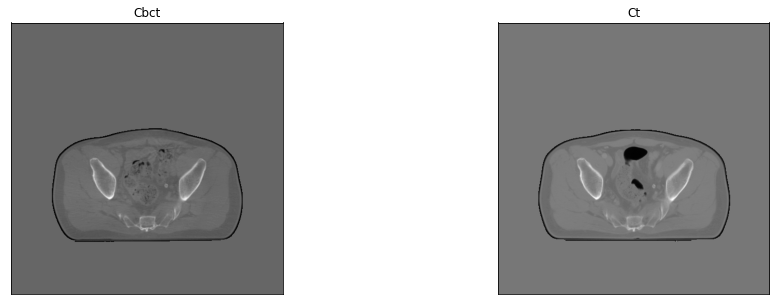

In [17]:
visualize(
    cbct = x.squeeze(),
    ct = y.squeeze()
)

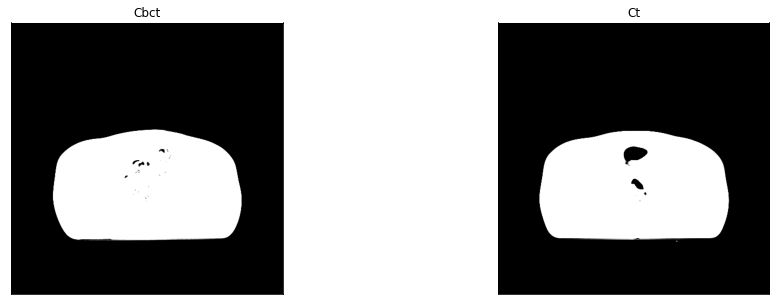

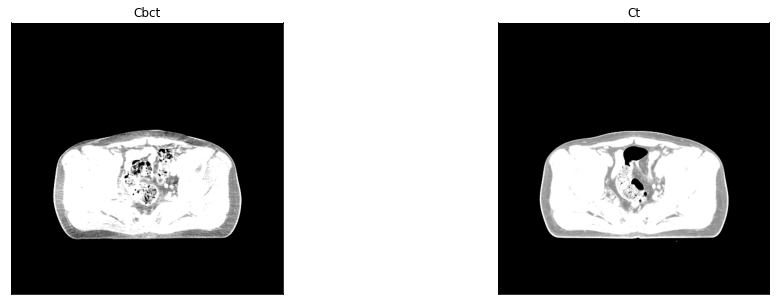

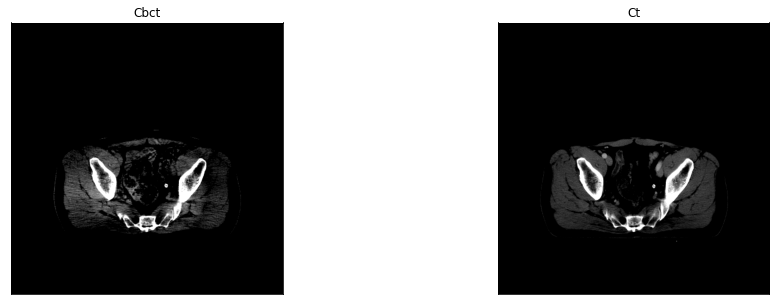

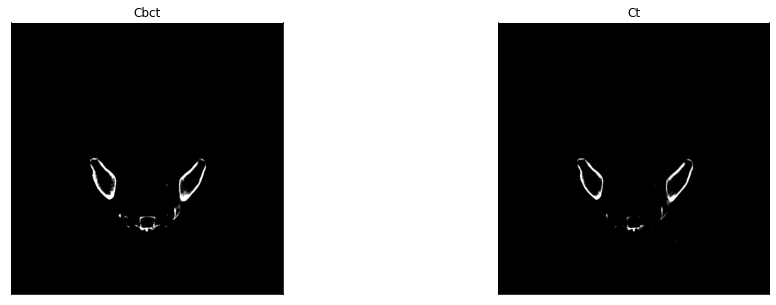

In [18]:
for i in range(0, len(hu_bins), 2):
    x = hu_bins[i]
    y = hu_bins[i+1]
    visualize(
        cbct = x.squeeze(),
        ct = y.squeeze()
    )

In [19]:
x.shape, y.shape

((1, 512, 512), (1, 512, 512))

In [21]:
x_max = 0
x_min = 512
y_max = 0
y_min = 512

In [26]:
for data in trainset:
    _, _, cbct, ct, *_ = data
    
    cbct = (cbct.squeeze() * 255).astype(np.uint8)
    
    cnts, hier = cv2.findContours(cbct.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts, key = cv2.contourArea)
    c = c.squeeze()
    
    xmax, ymax = c.max(axis=0)
    xmin, ymin = c.min(axis=0)
    
    if xmax > x_max:
        x_max = xmax
    if xmin < x_min:
        x_min = xmin
    if ymax > y_max:
        y_max = ymax
    if ymin < y_min:
        y_min = ymin

In [27]:
xmax

438

In [28]:
xmin

82

In [29]:
ymax

349

In [30]:
ymin

96